# Tarea 2: NLP, RNNs y Transformer

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import re

import numpy as np              # Procesamiento numérico
import pandas as pd             # Manipulación de conjuntos de datos
import matplotlib.pyplot as plt # Gráficos

import matplotlib.ticker as ticker

from tqdm import tqdm

from torch.utils.data import DataLoader, Subset

import torch
import torch.nn as nn
import torch.nn.functional as F

## Carga del dataset

Para la tarea se utilizará el dataset IMDB, el cual consiste en reseñas de películas con sus respectivas etiquetas de si es una reseña positiva o negativa.

El dataset se encuentra disponible en HuggingFace, asi que se puede cargar directamente.

**Nota:** Para descargar el dataset se tiene que instalar previamente la librería "datasets"

In [570]:
# # installing datasets package
# !pip install datasets

In [3]:
from datasets import load_dataset

c:\Users\Bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = load_dataset("stanfordnlp/imdb")

Using the latest cached version of the dataset since stanfordnlp/imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at C:\Users\Bruno\.cache\huggingface\datasets\stanfordnlp___imdb\plain_text\0.0.0\e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Sat May 11 19:55:56 2024).


In [5]:
data_train = pd.DataFrame(dataset["train"])
data_test = pd.DataFrame(dataset["test"])

# shuffle datasets

data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)

data_train.head()

,text,label
0,There should be more movies about our Native A...,1
1,"""The Matador"" is a dark comedy starring Pierce...",1
2,This is mostly a story about the growing relat...,1
3,I remember this series so well. It was excelle...,1
4,I like musicals but as a Dickens fan I HATE th...,0


In [6]:
# fraction dataset

fraction = 1
data_train = data_train.sample(frac=fraction).reset_index(drop=True)
data_test = data_test.sample(frac=fraction).reset_index(drop=True)

In [7]:
# tokenization
from nltk.tokenize import word_tokenize
import nltk
from bs4 import BeautifulSoup

nltk.download('punkt')

token_data_train = data_train.copy()
token_data_test = data_test.copy()

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    # Remove special characters and multiple spaces
    text = re.sub(r'[^a-zA-Z0-9\s.,]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    return text.strip()

token_data_train["text"] = token_data_train["text"].apply(clean_text)
token_data_test["text"] = token_data_test["text"].apply(clean_text)

token_data_train["text"] = token_data_train["text"].apply(word_tokenize)
token_data_test["text"] = token_data_test["text"].apply(word_tokenize)

token_data_train.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Bruno\AppData\Local\Temp\ipykernel_18044\1763248502.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text(separator=" ")


,text,label
0,"[oscar, wilde, s, comedy, of, manners, ,, perh...",0
1,"[no, nonsense, inspector, hollaway, a, solid, ...",1
2,"[no, ,, i, haven, t, read, the, stephen, king,...",0
3,"[this, worldwide, was, the, cheap, man, s, ver...",0
4,"[i, had, low, expectations, for, this, movie, ...",1


In [8]:
# vocabulary
from collections import Counter

vocab = Counter()

for text in token_data_train["text"]:
    vocab.update(text)

In [9]:
# Define the vocabulary size based on the most common words
vocabulary_size = 20000

# Get the most common words up to the specified vocabulary size
most_common_words = vocab.most_common(vocabulary_size)
print(most_common_words[:10])

# Define num_embeddings
vocab_size = vocabulary_size + 2

# Create word-to-index mapping with padding and unknown tokens
word_to_index = {word: index + 2 for index, (word, count) in enumerate(most_common_words)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = 1

# Create index-to-word mapping
index_to_word = {index: word for word, index in word_to_index.items()}
index_to_word[0] = "<PAD>"
index_to_word[1] = "<UNK>"

# Define a function to encode text using the word-to-index mapping
def encode_text(text):
    return [word_to_index.get(word, 1) for word in text]

# Apply the encoding function to the 'text' column of token_data_train and token_data_test
token_data_train["text"] = token_data_train["text"].apply(encode_text)
token_data_test["text"] = token_data_test["text"].apply(encode_text)

# Display the modified token_data_train
token_data_train.head()

[('the', 336136), (',', 275888), ('.', 269453), ('and', 164054), ('a', 162713), ('of', 145851), ('to', 135700), ('is', 107326), ('it', 96103), ('in', 93922)]


,text,label
0,"[717, 10826, 15, 211, 7, 7116, 3, 384, 2, 1, 2...",0
1,"[60, 1850, 2943, 1, 6, 1145, 469, 36, 302, 730...",1
2,"[60, 3, 12, 753, 25, 334, 2, 1642, 611, 647, 9...",0
3,"[13, 9139, 16, 2, 702, 128, 15, 315, 7, 50, 2,...",0
4,"[12, 70, 363, 1386, 18, 13, 20, 3, 21, 12, 16,...",1


In [10]:
def pad_text(text, length):
    return text[:length] if len(text) > length else text + [0] * (length - len(text))

In [578]:
# padding

text_max_length = np.max(token_data_train["text"].apply(len))
text_mean_length = int(np.mean(token_data_train["text"].apply(len)))
text_median_length = int(np.median(token_data_train["text"].apply(len)))

print(f"Max length: {text_max_length}")
print(f"Mean length: {text_mean_length}")
print(f"Median length: {text_median_length}")

token_data_train["text"] = token_data_train["text"].apply(pad_text, length=text_median_length//4)
token_data_test["text"] = token_data_test["text"].apply(pad_text, length=text_max_length)

token_data_train.head()

Max length: 2699
Mean length: 260
Median length: 194


,text,label
0,"[798, 4988, 301, 37, 15985, 38, 9, 45, 397, 47...",1
1,"[12, 843, 18, 257, 165, 389, 3, 257, 153, 512,...",1
2,"[12, 220, 13, 20, 532, 14, 10, 63, 31, 32, 7, ...",0
3,"[6, 1597, 5, 29, 241, 447, 28, 47, 1943, 56, 2...",0
4,"[12, 67, 792, 8, 41, 13, 20, 21, 11, 2, 133, 1...",0


In [579]:
# create validation set

validation_size = 0.2
validation_samples = int(len(token_data_train) * validation_size)

final_val = token_data_train[:validation_samples]
final_train = token_data_train[validation_samples:]
final_test = token_data_test

In [580]:
final_train.reset_index(drop=True, inplace=True)
final_train.head()

,text,label
0,"[1829, 5, 1829, 16, 32, 7, 12967, 4136, 15, 29...",1
1,"[13, 22, 16, 546, 21, 2323, 5, 2, 116, 401, 1,...",0
2,"[90, 8, 1578, 364, 9412, 81, 9, 6, 897, 22, 4,...",1
3,"[1593, 5, 605, 3, 12, 118, 13, 20, 4, 17, 52, ...",1
4,"[450, 24, 6, 528, 4845, 647, 36, 32, 59, 241, ...",0


 Por motivos de costo computacional y tiempo de entrenamiento, para la tarea pueden considerar una proporción del dataset,  por ejemplo el 10%. Pero tenga en consideración que si el tamaño del dataset es muy pequeño el rendimiento del modelo se verá afectado negativamente.

In [11]:
# PyTorch datasets

from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data["text"][index]), torch.tensor(self.data["label"][index])

In [582]:
train_dataset = IMDBDataset(final_train)
val_dataset = IMDBDataset(final_val)
test_dataset = IMDBDataset(final_test)

# Report split sizes
print('Training set has {} instances'.format(len(final_train)))
print('Validation set has {} instances'.format(len(final_val)))
print('Test set has {} instances'.format(len(final_test)))

# PyTorch dataloaders

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training set has 20000 instances
Validation set has 5000 instances
Test set has 25000 instances


## Parte 1: Redes Neuronales Recurrentes (RNNs)

### Actividad 1

Responda las siguientes preguntas:


*   ¿Cuáles son las principales características de las redes neuronales recurrentes?

    **Respuesta:** Las redes neuronales recurrentes, como su nombre indica, poseen conexiones recurrentes
    lo que permite que la red mantenga una memoria de los datos que ha procesado previamente,
    de forma que el _output_ en un estado particual esta influenciado no solo por su _input_ actual
    sino también por los _inputs_ previos.
    
    Las RNN tienen la capacidad de recibir _inputs_ de longitud variable y producir _outputs_ de longitud variable.

*   ¿Cuáles son las desventajas y limitaciones de las redes RNNs?

    **Respuesta:** Las RNNs sufren del problema de desvanecimiento y explosión del gradiente, lo que
    dificulta el entrenamiento de la red. Además, las RNNs tienen dificultades para mantener
    la memoria a largo plazo, lo que limita su capacidad para recordar información relevante
    de _inputs_ muy antiguos. Por el contrario, las RNNs también tienen problemas para olvidar
    información irrelevantes de _inputs_ recientes que no son relevantes para el _output_.

*   Menciona y describa brevemente al menos dos variantes a la arquitectura de RNNs simples.

    **Respuesta:** LSTM: Las redes LSTM (Long Short-Term Memory) son una variante de las RNNs que
    intentan solucionar el problema de la memoria a largo plazo. Las LSTM poseen una estructura
    más compleja que las RNNs tradicionales, con una estructura de celdas que permiten mantener
    la memoria a largo plazo y olvidar información irrelevante.

    GRU: Las redes GRU (Gated Recurrent Unit) son una variante de las RNNs que intentan simplificar
    la estructura de las LSTM, eliminando la estructura de celdas y manteniendo solo las puertas
    de olvido y actualización. Las GRU son más simples que las LSTM y tienen menos parámetros,
    lo que las hace más fáciles de entrenar y menos propensas al sobreajuste.

    Modelos de atención: Los modelos de atención son una variante de las RNNs que permiten
    que la red se enfoque en partes específicas de la secuencia de _inputs_ para generar el _output_,
    asignando pesos a los _inputs_ en vez de asignar el mismo peso a todos los _inputs_ como lo hacen
    las RNNs tradicionales. 

### Actividad 2

Implemente una red RNN simple y realice su entrenamiento con el dataset preprocesado. Para el pre-procesamiento use el método de la Actividad 1.

La siguiente celda contiene el esqueleto de la red. Puede usarlo como referencia para su implementación o realizar una propia.

In [626]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, dropout=0.2):
        super(SimpleRNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, nonlinearity='relu', dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # RNN
        out, hidden = self.rnn(x)
        
        out = self.fc(out[:, -1, :])
        
        return out

In [627]:
simple_model = SimpleRNN(vocab_size, 128, 128, 1, dropout=0.2)

c:\Users\Bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [628]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.005
optimizer = torch.optim.Adam(simple_model.parameters(), lr=lr)

In [629]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model.to(device)

SimpleRNN(
  (embedding): Embedding(20002, 128)
  (rnn): RNN(128, 128, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [630]:
def train(num_epochs, model, criterion, optimizer, train_dataloader, val_dataloader):
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i, (texts, labels) in enumerate(tqdm(train_dataloader)):
            if torch.isnan(texts).any() or torch.isinf(texts).any():
                print(f"Found NaN or inf in texts at iteration {i}")
            if torch.isnan(labels).any() or torch.isinf(labels).any():
                print(f"Found NaN or inf in labels at iteration {i}")
            if (texts >= vocabulary_size).any():
                print(f"Found out-of-range values in texts at iteration {i}")
            texts = texts.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(texts)
            # print(output)
            output = output.squeeze()  # Remove the extra dimension from the output
            # print(output, labels.float())

            loss = criterion(output, labels.float())  # Compute the loss
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping
            optimizer.step()

        losses.append(loss.item())
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

        model.eval()

        with torch.no_grad():
            for i, (texts, labels) in enumerate(tqdm(val_dataloader)):
                texts = texts.to(device)
                labels = labels.to(device)

                output = model(texts)
                output = output.squeeze()

                val_loss = criterion(output, labels.float())

        val_losses.append(val_loss.item())
        print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, num_epochs, val_loss.item()))

    return (losses, val_losses)

In [631]:
losses, val_losses = train(5, simple_model, criterion, optimizer, train_dataloader, val_dataloader)

100%|██████████| 157/157 [00:01<00:00, 106.73it/s]


Epoch [1/5], Loss: 0.7220


100%|██████████| 40/40 [00:00<00:00, 254.78it/s]


Epoch [1/5], Validation Loss: 0.6653


100%|██████████| 157/157 [00:01<00:00, 115.19it/s]


Epoch [2/5], Loss: 0.5202


100%|██████████| 40/40 [00:00<00:00, 239.52it/s]


Epoch [2/5], Validation Loss: 0.6468


100%|██████████| 157/157 [00:01<00:00, 108.80it/s]


Epoch [3/5], Loss: 0.4446


100%|██████████| 40/40 [00:00<00:00, 196.08it/s]


Epoch [3/5], Validation Loss: 0.6902


100%|██████████| 157/157 [00:01<00:00, 105.44it/s]


Epoch [4/5], Loss: 0.5733


100%|██████████| 40/40 [00:00<00:00, 223.47it/s]


Epoch [4/5], Validation Loss: 0.6284


100%|██████████| 157/157 [00:01<00:00, 103.02it/s]


Epoch [5/5], Loss: 0.3548


100%|██████████| 40/40 [00:00<00:00, 181.00it/s]

Epoch [5/5], Validation Loss: 1.0001


In [634]:
# PATH = './simple_rnn.pth'
# torch.save(simple_model.state_dict(), PATH)

In [591]:
# PATH = './simple_rnn.pth'
# simple_model = SimpleRNN(num_embeddings, 128, 128, 1)
# simple_model.load_state_dict(torch.load(PATH))
# simple_model.to(device)

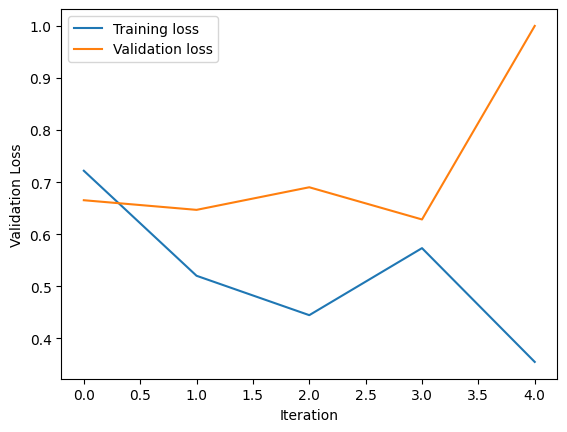

In [632]:
# plot losses

def plot(losses, val_losses):

    plt.plot(losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.legend()

    plt.xlabel("Iteration")
    plt.ylabel("Validation Loss")

    plt.show()

plot(losses, val_losses)

In [633]:
# Test accuracy

def test(model, dataloader):

    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for texts, labels in tqdm(dataloader):
            texts = texts.to(device)
            labels = labels.to(device)

            output = model(texts)
            output = output.squeeze()

            predictions = torch.round(torch.sigmoid(output))

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    accuracy = correct / total
    print(f"Test accuracy: {accuracy * 100:.2f}%")

test(simple_model, test_dataloader)

100%|██████████| 196/196 [00:13<00:00, 14.60it/s]

Test accuracy: 74.06%


### Actividad 3

Implemente una red variante al RNN clásico, como un LSTM, GRU, Bi-LSTM, entre otros. Realice el entrenamiento del modelo con el mismo dataset. Realice un breve análisis sobre las diferencias en términos de los resultados, tiempo de ejecución y aspectos que le parezcan relevantes, entre la red implementada en la actividad previa y la red implementada en esta actividad.

In [741]:
class VariantRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, dropout=0.2):
        super(VariantRNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True, num_layers=1, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # RNN
        out, hidden = self.rnn(x)
        
        out = self.fc(out[:, -1, :])
        
        return out

In [742]:
variant_model = VariantRNN(vocab_size, 128, 128, 1, dropout=0.2)
variant_model.to(device)

VariantRNN(
  (embedding): Embedding(20002, 128)
  (rnn): GRU(128, 128, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [743]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.005
optimizer = torch.optim.Adam(variant_model.parameters(), lr=lr)

In [744]:
losses, val_losses = train(5, variant_model, criterion, optimizer, train_dataloader, val_dataloader)

100%|██████████| 157/157 [00:01<00:00, 93.34it/s] 


Epoch [1/5], Loss: 0.4580


100%|██████████| 40/40 [00:00<00:00, 242.42it/s]


Epoch [1/5], Validation Loss: 0.5178


100%|██████████| 157/157 [00:01<00:00, 102.77it/s]


Epoch [2/5], Loss: 0.3619


100%|██████████| 40/40 [00:00<00:00, 221.00it/s]


Epoch [2/5], Validation Loss: 0.4520


100%|██████████| 157/157 [00:01<00:00, 100.38it/s]


Epoch [3/5], Loss: 0.2127


100%|██████████| 40/40 [00:00<00:00, 222.22it/s]


Epoch [3/5], Validation Loss: 0.3654


100%|██████████| 157/157 [00:01<00:00, 98.68it/s]


Epoch [4/5], Loss: 0.2312


100%|██████████| 40/40 [00:00<00:00, 217.40it/s]


Epoch [4/5], Validation Loss: 0.3964


100%|██████████| 157/157 [00:01<00:00, 97.33it/s]


Epoch [5/5], Loss: 0.1012


100%|██████████| 40/40 [00:00<00:00, 217.39it/s]

Epoch [5/5], Validation Loss: 0.5109


In [747]:
# PATH = './variant_rnn.pth'
# torch.save(variant_model.state_dict(), PATH)

In [616]:
# PATH = './variant_rnn.pth'
# variant_model = VariantRNN(num_embeddings, 128, 128, 1)
# variant_model.load_state_dict(torch.load(PATH))
# variant_model.to(device)

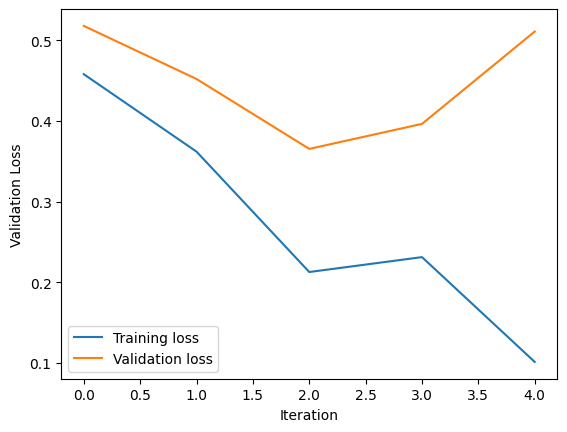

In [745]:
plot(losses, val_losses)

In [746]:
test(variant_model, test_dataloader)

100%|██████████| 196/196 [00:13<00:00, 14.02it/s]

Test accuracy: 82.40%


#### SimpleRNN vs VariantRNN

Los resultados obtenidos por VariantRNN son mejores que los de la RNN simple. Para VariantRNN se usó
una RNN tipo GRU, que es una variante de las RNNs que intenta solucionar los problemas de las RNNs
tradicionales. En este caso, la GRU obtuvo mejores resultados que la RNN simple, con una precisión
de 82.4%, mientras que la RNN simple tuvo una precisión de 74.06%.

En cuanto a los tiempos de entrenamiento, se tiene que fueron bastante parecidos, aunque levemente
más lento el entrenamiento de la GRU, así como también en el tiempo de testeo.

Finalmente, en términos de implementación en código, son realmente muy parecidos, con la única diferencia
de que en la GRU se usa una capa de tipo GRU en vez de una capa de tipo RNN.

Cabe destacar que en ambos casos mi entrenamiento tuvo problemas de _overfitting_ y de gradientes, ya
que el _validation_loss_ se volvía muy inestable y no lograba disminuir de forma constante, por lo que
opté por entrenar con un número de _epochs_ menor para evitar el _overfitting_ y secuencias de texto
más cortas para evitar problemas con los gradientes.

## Parte 2: Transformer

### Actividad 4

Responda las siguientes preguntas:



*   ¿Cuáles son los principales aspectos de las redes Transformer?
¿Qué desafíos específicos de las RNNs intenta superar la arquitectura de los Transformers?

    **Respuesta:**....

*   ¿Cuáles son las diferencias entre las capas cross-attention y self-attention?

    **Respuesta:**....

*   ¿Cuáles son las principales características del encoder y el decoder de una red Transformer?

    **Respuesta:**....

*   ¿En qué casos se aplica modelos de tipo encoder? En qué casos se aplica modelos de tipo decoder? ¿En qué casos se aplica modelos de tipo encoder decoder? Responda y justifique su respuesta brevemente.

    **Respuesta:**....

### Actividad 5

En particular, la tarea será sobre generación de reseñas. Es decir que tendrán que implementar una red Transformer y entrenarla con el dataset IMDB para generar texto de reseñas de películas.

A medida que progresa el entrenamiento, muestre algunas instancias de salida del texto generado por el modelo. Para ello considere los puntos inicial, intermedio y final del entrenamiento. Realice un análisis sobre el texto generado y explique brevemente cómo el modelo es capaz de generar texto de reseñas.

Es importante que argumente su elección de los parámetros e hiperparámetros que vaya a utilizar, tales como: cantidad de capas, cantidad de neuronas por capa, función de activación, función de pérdida, etc. En particular, describa el método utilizado para la tokenización de los datos.

En base a: https://debuggercafe.com/text-generation-with-transformers/

In [6]:
# tokenization
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

token_data_train = data_train.copy()
token_data_test = data_test.copy()

# concatenate both datasets

token_data = pd.concat([data_train, data_test], ignore_index=True)

# Fraction the dataset

fraction = 0.1
token_data = token_data.sample(frac=fraction).reset_index(drop=True)

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    # Remove special characters and multiple spaces
    text = re.sub(r'[^a-zA-Z0-9\s.,]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

token_data["text"] = token_data["text"].apply(clean_text)
token_data["text"] = token_data["text"].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Bruno\AppData\Local\Temp\ipykernel_17520\2561846294.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text(separator=" ")


In [7]:
# Create a list of sequences of words from the 'text' column

list_of_lists = token_data["text"].tolist()

# Merge all sequences into a single list

all_words = [word for sequence in list_of_lists for word in sequence]

# Subdivide the list into smaller lists of SEQUENCE_LENGTH words

SEQUENCE_LENGTH = 64

sequences = [all_words[i:i+SEQUENCE_LENGTH] for i in range(len(all_words)-SEQUENCE_LENGTH)]

In [8]:
# vocabulary
from collections import Counter

words_count = Counter(all_words)

vocab = list(words_count.keys())

vocab_size = len(vocab)

word_to_int = {word: index for index, word in enumerate(vocab)}
int_to_word = {index: word for index, word in enumerate(vocab)}

In [9]:
# PyTorch datasets

from torch.utils.data import Dataset

class IMDBTextDataset(Dataset):
    def __init__(self, samples, word_to_int):
        self.samples = samples
        self.word_to_int = word_to_int

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        input_seq = torch.LongTensor([self.word_to_int[word] for word in sample[:-1]])
        target_seq = torch.LongTensor([self.word_to_int[word] for word in sample[1:]])
        return input_seq, target_seq

In [20]:
BATCH_SIZE = 64

generation_dataset = IMDBTextDataset(sequences, word_to_int)

In [21]:
generation_dataloader = DataLoader(generation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
def generate_triangular_mask(size):
    mask = torch.tril(torch.ones(size, size))
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [23]:
class PostionalEncoding(nn.Module):
    def __init__(self, max_len, d_model, dropout=0.2):
        super(PostionalEncoding, self).__init__()

        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [24]:
class MyModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_layers, num_heads, dropout=0.2):
        super(MyModel, self).__init__()

        self.pos_encoder = PostionalEncoding(SEQUENCE_LENGTH, embedding_size)
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=embedding_size, nhead=num_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer=self.decoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        emb = self.embedding(x)
        input_mask = generate_triangular_mask(x.size(1)).to(x.device)

        x = self.pos_encoder(emb)
        x = self.decoder(x, memory=x, tgt_mask=input_mask, memory_mask=input_mask)
        x = self.dropout(x)
        out = self.fc(x)
        return out

In [30]:
EPOCHS = 1
LR = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel(vocab_size, 128, 2, 4, dropout=0.2).to(device)

In [61]:
def return_int_vector(text):
    words = text.split()
    input_seq = torch.LongTensor([word_to_int[word] for word in words[-SEQUENCE_LENGTH:]]).unsqueeze(0)
    return input_seq

def sample_next(predictions):
    probabilities = F.softmax(predictions[:, -1, :], dim=-1).to(device)
    next_token = torch.argmax(probabilities)
    return int(next_token.to(device))

def text_generator(length, model, sentence="The"):
    model.eval()
    output_text = sentence
    for i in range(length):
        int_vector = return_int_vector(sentence)
        if len(int_vector) >= SEQUENCE_LENGTH:
            break
        int_vector = int_vector.to(device)
        with torch.no_grad():
            output = model(int_vector)
        next_token = sample_next(output)
        sentence += " " + int_to_word[next_token]
        if int_to_word[next_token] == "s":
            output_text += "'s"
        elif int_to_word[next_token] == "t" and output_text[-1] == "n":
            output_text += "'t"
        elif int_to_word[next_token] == "m" and output_text[-1] == "I":
            output_text += "'m"
        elif int_to_word[next_token] not in [".", ",", "!", "?"]:
            output_text += " " + int_to_word[next_token]
        else:
            output_text += int_to_word[next_token]
    print(output_text)

In [51]:
# No training

text_generator(100, model)

The film is a little bit of a little bit of a pickle, but it's a very good movie. The story is so bad that it's a shame that it's a good movie. The story is so bad that it's a shame that it's a shame that it's a shame that it's a good movie. It's a shame that it's a good movie. It's a shame that it's a good movie. It's a shame that it's a good movie. It's


In [53]:
def train(model, epochs, criterion, optimizer, train_dataloader, accumulation_steps=1):
    losses = []
    counter = 0
    for epoch in range(epochs):
        model.train()
        for input_sequence, target_sequence in tqdm(train_dataloader):
            counter +=1
            input_sequence = input_sequence.to(device)
            target_sequence = target_sequence.to(device)

            output = model(input_sequence)
            output = output.view(-1, vocab_size)
            target_sequence = target_sequence.view(-1)

            loss = criterion(output, target_sequence)
            loss.backward()

            if (counter + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            if (counter + 1) % 1000 == 0:
                losses.append(loss.item())
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

In [54]:
train(model, EPOCHS, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=LR), generation_dataloader, accumulation_steps=4)

  5%|▍         | 1001/20225 [01:04<20:16, 15.81it/s]

Epoch [1/1], Loss: 4.54587459564209


 10%|▉         | 2001/20225 [02:07<19:21, 15.69it/s]

Epoch [1/1], Loss: 4.558750152587891


 15%|█▍        | 3001/20225 [03:10<18:07, 15.84it/s]

Epoch [1/1], Loss: 4.5575175285339355


 20%|█▉        | 4001/20225 [04:14<17:07, 15.79it/s]

Epoch [1/1], Loss: 4.412294387817383


 25%|██▍       | 5001/20225 [05:17<15:44, 16.11it/s]

Epoch [1/1], Loss: 4.416632175445557


 30%|██▉       | 6001/20225 [06:20<14:41, 16.14it/s]

Epoch [1/1], Loss: 4.462799072265625


 35%|███▍      | 7001/20225 [07:23<13:54, 15.85it/s]

Epoch [1/1], Loss: 4.432182788848877


 40%|███▉      | 8001/20225 [08:26<12:49, 15.88it/s]

Epoch [1/1], Loss: 4.5004143714904785


 45%|████▍     | 9001/20225 [09:29<11:36, 16.11it/s]

Epoch [1/1], Loss: 4.297603130340576


 49%|████▉     | 10001/20225 [10:32<10:53, 15.63it/s]

Epoch [1/1], Loss: 4.37116003036499


 54%|█████▍    | 11001/20225 [11:35<09:32, 16.10it/s]

Epoch [1/1], Loss: 4.343756198883057


 59%|█████▉    | 12001/20225 [12:39<08:38, 15.87it/s]

Epoch [1/1], Loss: 4.260626316070557


 64%|██████▍   | 13001/20225 [13:42<07:36, 15.84it/s]

Epoch [1/1], Loss: 4.341666221618652


 69%|██████▉   | 14001/20225 [14:45<06:27, 16.07it/s]

Epoch [1/1], Loss: 4.342681884765625


 74%|███████▍  | 15001/20225 [15:48<05:28, 15.92it/s]

Epoch [1/1], Loss: 4.272383213043213


 79%|███████▉  | 16001/20225 [16:51<04:26, 15.87it/s]

Epoch [1/1], Loss: 4.259954929351807


 84%|████████▍ | 17001/20225 [17:54<03:22, 15.93it/s]

Epoch [1/1], Loss: 4.292387008666992


 89%|████████▉ | 18001/20225 [18:57<02:19, 15.97it/s]

Epoch [1/1], Loss: 4.269377708435059


 94%|█████████▍| 19001/20225 [20:00<01:15, 16.18it/s]

Epoch [1/1], Loss: 4.263708591461182


 99%|█████████▉| 20001/20225 [21:02<00:14, 15.85it/s]

Epoch [1/1], Loss: 4.197737693786621


100%|██████████| 20225/20225 [21:17<00:00, 15.84it/s]


In [52]:
# One epoch: ~20000 iterations each

text_generator(100, model)

The film is a little bit of a little bit of a pickle, but it's a very good movie. The story is so bad that it's a shame that it's a good movie. The story is so bad that it's a shame that it's a shame that it's a shame that it's a good movie. It's a shame that it's a good movie. It's a shame that it's a good movie. It's a shame that it's a good movie. It's


In [62]:
# Two epochs: ~20000 iterations each

text_generator(100, model)

The movie is a bit of a little bit of a letdown. I don't know what I'm going to say, I'm not sure why this movie is a good movie. I don't know what I can say is that the movie is a good movie. I can't believe that this movie was made in the first place. I was expecting a lot of the movie, but I was very disappointed. The acting was good, the acting was terrible, the acting was terrible. The acting was terrible


La siguiente celda es un ejemplo del entrenamiento de su modelo y de la generación de reseñas que realiza su modelo entrenado. En este caso se muestra la generación de 2000 tokens.

In [ ]:
model = MyModel()

train(model)

num_tokens = 2000

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=num_tokens)[0].tolist()))

0.224306 M parameters
step 0: train loss 5.3014, val loss 5.3014
step 100: train loss 2.7339, val loss 2.7166
step 200: train loss 2.5480, val loss 2.5588
step 300: train loss 2.4732, val loss 2.4783
step 400: train loss 2.3983, val loss 2.3997
step 500: train loss 2.3159, val loss 2.3250
step 600: train loss 2.2822, val loss 2.2755
step 700: train loss 2.2273, val loss 2.2159
step 800: train loss 2.1654, val loss 2.1702
step 900: train loss 2.1472, val loss 2.1538
step 1000: train loss 2.1127, val loss 2.1100
step 1100: train loss 2.0843, val loss 2.0968
step 1200: train loss 2.0706, val loss 2.0647
step 1300: train loss 2.0495, val loss 2.0576
step 1400: train loss 2.0166, val loss 2.0264
step 1500: train loss 2.0031, val loss 1.9983
step 1600: train loss 1.9816, val loss 1.9836
step 1700: train loss 1.9620, val loss 1.9739
step 1800: train loss 1.9528, val loss 1.9667
step 1900: train loss 1.9252, val loss 1.9404
step 2000: train loss 1.9206, val loss 1.9348
step 2100: train loss 1.

In [ ]:
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Review: (TH Of E NOU'NYTN CE) No jealloa girl suwital. Unounder. I gon that HANEY SENK. SHEEG. All is helpinnes, that is job and AltohCRE: Fronk AGE A Sdenterns Review: Lusbe Allf Flaegray Ram-, high scist, butment was little nothim to yet. There been turn the good much, and thought be ver factuul to one yous heldined expy woutch be in creadity for Orché no culla real on monstanshing takeour ly grourie and some and panter and about my about crist? Well by infully. She Nebs and I wald they MTIE FOMD, Alexra TV Oh- hard, it those diffect, tries and Fene, more get yong trody or bad a torie writh this, you pay.<br /> /><br />I `00 a liude show ence have unding the tinfully. He right Combering Jet encesten with (looking, stakes) is a lost get it on in the film, but that stophiles it the bere I watch zitious that scene the `T.. Nonzeplay? The goals bad do - in clasks of his for than asks and to but. On bout, doire and relazing, the and the criseum and tract crimitly watchonde thip is the sur

### Actividad 6

A partir del modelo generativo de la anterior actividad, realice los ajustes necesarios al modelo para mejorar la calidad de las reseñas generadas. Se espera que el modelo sea capaz de generar reseñas de mejor calidad en comparación a la actividad previa. Para ello, investigue y agregue otros datasets públicos de reseñas de películas u otro tipo.